# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

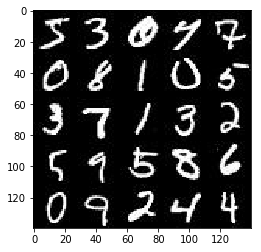

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

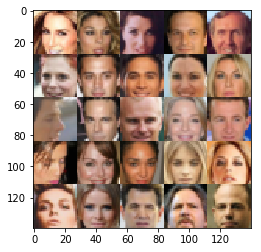

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: Leaky ReLU factor (additionally added)
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):       
        # Image size is 28x28x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(x1, x1 * alpha)
        
        # Image size is 14x14x64
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2 * alpha)
        
        # Image size is 8x8x128
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * alpha)
        
        flat = tf.reshape(x3, (-1, 8*8*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: Leaky ReLU (added)
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256, activation=None) 
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1 * alpha)
        # 14x14x256
        
        #x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='same')
        #x2 = tf.layers.batch_normalization(x2, training=is_train)
        #x2 = tf.maximum(x2, x2 * alpha)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, x3 * alpha)
        # 14x14x128
        
        # Output layer 
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        # 28 x 28 x outchannel_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model with previous functions
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) #mimic input channels
    d_train_opt, g_train_opt= model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Verbose variable
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizzzzzzzers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z}) # needs images?
                
                # Verbose output
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 50 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0358... Generator Loss: 22.3141
Epoch 1/2... Discriminator Loss: 0.0582... Generator Loss: 13.2522
Epoch 1/2... Discriminator Loss: 4.5494... Generator Loss: 0.1048
Epoch 1/2... Discriminator Loss: 2.1028... Generator Loss: 0.2755
Epoch 1/2... Discriminator Loss: 0.2362... Generator Loss: 2.7849


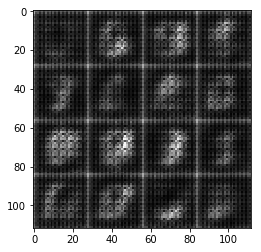

Epoch 1/2... Discriminator Loss: 0.6317... Generator Loss: 3.7613
Epoch 1/2... Discriminator Loss: 1.8857... Generator Loss: 0.2786
Epoch 1/2... Discriminator Loss: 0.6656... Generator Loss: 1.2608
Epoch 1/2... Discriminator Loss: 0.3895... Generator Loss: 5.8976
Epoch 1/2... Discriminator Loss: 0.3496... Generator Loss: 4.3638


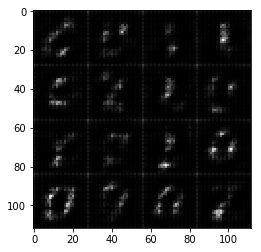

Epoch 1/2... Discriminator Loss: 0.1913... Generator Loss: 2.6552
Epoch 1/2... Discriminator Loss: 0.1080... Generator Loss: 2.7607
Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 3.2014
Epoch 1/2... Discriminator Loss: 0.0351... Generator Loss: 5.8073


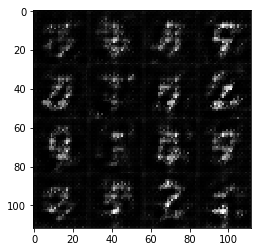

Epoch 1/2... Discriminator Loss: 0.0191... Generator Loss: 4.7183
Epoch 1/2... Discriminator Loss: 5.5100... Generator Loss: 11.2692
Epoch 1/2... Discriminator Loss: 0.1860... Generator Loss: 2.4753
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 0.3868


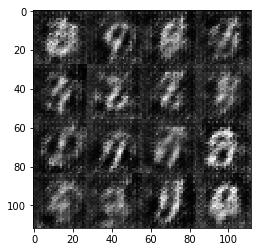

Epoch 1/2... Discriminator Loss: 0.1135... Generator Loss: 2.7677
Epoch 1/2... Discriminator Loss: 2.8748... Generator Loss: 0.0782
Epoch 1/2... Discriminator Loss: 0.1694... Generator Loss: 2.6678
Epoch 1/2... Discriminator Loss: 1.7849... Generator Loss: 0.2639
Epoch 1/2... Discriminator Loss: 0.0913... Generator Loss: 2.9434


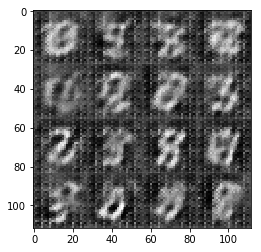

Epoch 1/2... Discriminator Loss: 0.0194... Generator Loss: 7.2883
Epoch 1/2... Discriminator Loss: 1.5519... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 0.1424... Generator Loss: 5.5512
Epoch 1/2... Discriminator Loss: 2.2720... Generator Loss: 4.4014
Epoch 1/2... Discriminator Loss: 0.9248... Generator Loss: 0.6749


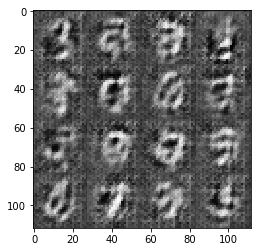

Epoch 1/2... Discriminator Loss: 0.1342... Generator Loss: 4.7765
Epoch 1/2... Discriminator Loss: 0.4254... Generator Loss: 3.9704
Epoch 1/2... Discriminator Loss: 2.7085... Generator Loss: 7.2024
Epoch 1/2... Discriminator Loss: 0.3752... Generator Loss: 1.5496
Epoch 1/2... Discriminator Loss: 0.1419... Generator Loss: 2.5993


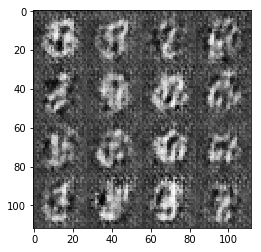

Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 0.3095... Generator Loss: 1.8894
Epoch 1/2... Discriminator Loss: 0.0286... Generator Loss: 7.2281
Epoch 1/2... Discriminator Loss: 0.1033... Generator Loss: 3.4236
Epoch 1/2... Discriminator Loss: 0.0236... Generator Loss: 4.5896


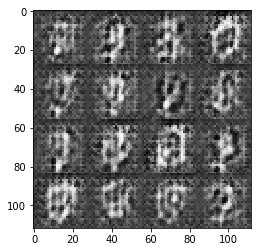

Epoch 1/2... Discriminator Loss: 0.0098... Generator Loss: 5.6575
Epoch 1/2... Discriminator Loss: 1.9530... Generator Loss: 0.2019
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.9264
Epoch 1/2... Discriminator Loss: 0.7342... Generator Loss: 3.3525
Epoch 1/2... Discriminator Loss: 2.1645... Generator Loss: 4.4778


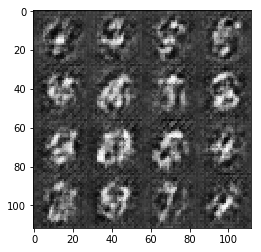

Epoch 1/2... Discriminator Loss: 0.9715... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 0.5920... Generator Loss: 0.9732
Epoch 1/2... Discriminator Loss: 0.6359... Generator Loss: 0.9250
Epoch 1/2... Discriminator Loss: 0.5276... Generator Loss: 1.1793
Epoch 1/2... Discriminator Loss: 0.1504... Generator Loss: 2.8225


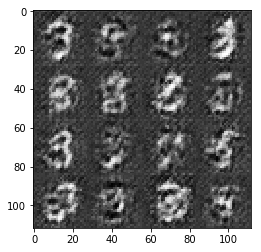

Epoch 1/2... Discriminator Loss: 0.0751... Generator Loss: 3.8238
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 3.8782
Epoch 1/2... Discriminator Loss: 0.5927... Generator Loss: 2.2025
Epoch 1/2... Discriminator Loss: 0.4292... Generator Loss: 1.5160
Epoch 1/2... Discriminator Loss: 0.0711... Generator Loss: 4.1714


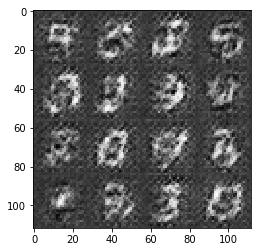

Epoch 1/2... Discriminator Loss: 0.0549... Generator Loss: 3.8685
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 0.1393... Generator Loss: 2.7075
Epoch 1/2... Discriminator Loss: 0.0380... Generator Loss: 4.2564
Epoch 1/2... Discriminator Loss: 0.0339... Generator Loss: 6.6698


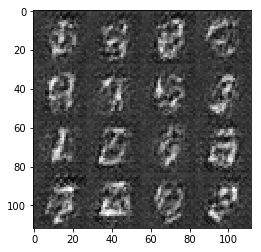

Epoch 1/2... Discriminator Loss: 0.0220... Generator Loss: 7.2310
Epoch 1/2... Discriminator Loss: 0.0121... Generator Loss: 5.5211
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 5.8967
Epoch 1/2... Discriminator Loss: 0.0245... Generator Loss: 4.2674
Epoch 1/2... Discriminator Loss: 0.0852... Generator Loss: 3.0852


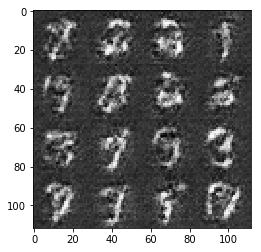

Epoch 1/2... Discriminator Loss: 0.0772... Generator Loss: 3.1467
Epoch 1/2... Discriminator Loss: 0.0472... Generator Loss: 3.8540
Epoch 1/2... Discriminator Loss: 0.2315... Generator Loss: 1.9603
Epoch 1/2... Discriminator Loss: 0.0653... Generator Loss: 3.1103
Epoch 1/2... Discriminator Loss: 0.1782... Generator Loss: 2.2529


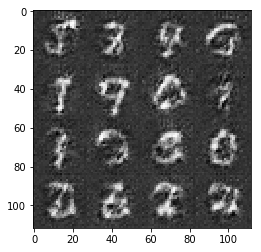

Epoch 1/2... Discriminator Loss: 0.0359... Generator Loss: 6.3634
Epoch 1/2... Discriminator Loss: 2.7807... Generator Loss: 0.0917
Epoch 1/2... Discriminator Loss: 0.5486... Generator Loss: 1.5441
Epoch 1/2... Discriminator Loss: 0.4443... Generator Loss: 2.1988
Epoch 1/2... Discriminator Loss: 0.4631... Generator Loss: 2.8904


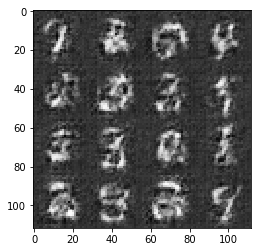

Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.5079
Epoch 1/2... Discriminator Loss: 1.0826... Generator Loss: 3.4699
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 3.8650
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.5916
Epoch 1/2... Discriminator Loss: 0.7047... Generator Loss: 0.8934


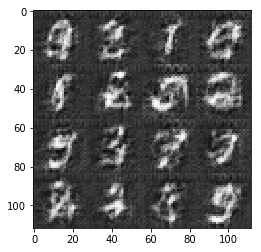

Epoch 1/2... Discriminator Loss: 0.3385... Generator Loss: 1.8317
Epoch 1/2... Discriminator Loss: 0.3768... Generator Loss: 1.5184
Epoch 1/2... Discriminator Loss: 0.5677... Generator Loss: 1.0243
Epoch 1/2... Discriminator Loss: 0.4889... Generator Loss: 1.2254
Epoch 1/2... Discriminator Loss: 0.1807... Generator Loss: 2.2527


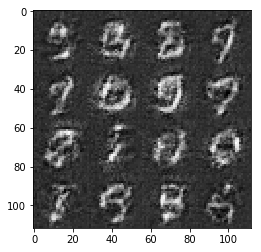

Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 0.9441... Generator Loss: 3.9539
Epoch 1/2... Discriminator Loss: 1.6337... Generator Loss: 0.3218
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 0.9375
Epoch 1/2... Discriminator Loss: 0.2840... Generator Loss: 1.8682


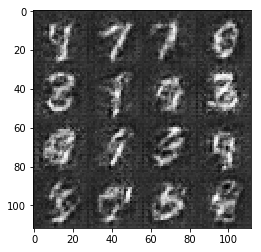

Epoch 1/2... Discriminator Loss: 0.3633... Generator Loss: 1.5728
Epoch 1/2... Discriminator Loss: 0.2183... Generator Loss: 1.9518
Epoch 1/2... Discriminator Loss: 0.2187... Generator Loss: 1.9722
Epoch 2/2... Discriminator Loss: 0.1107... Generator Loss: 2.5989
Epoch 2/2... Discriminator Loss: 0.1662... Generator Loss: 2.3600


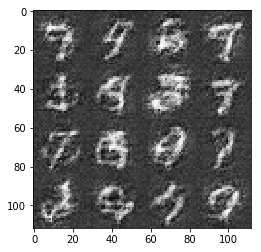

Epoch 2/2... Discriminator Loss: 0.1329... Generator Loss: 2.3729
Epoch 2/2... Discriminator Loss: 0.0325... Generator Loss: 3.8835
Epoch 2/2... Discriminator Loss: 0.1813... Generator Loss: 2.1115
Epoch 2/2... Discriminator Loss: 0.0242... Generator Loss: 4.2939
Epoch 2/2... Discriminator Loss: 0.0809... Generator Loss: 3.0494


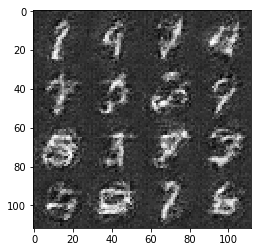

Epoch 2/2... Discriminator Loss: 0.0539... Generator Loss: 3.4810
Epoch 2/2... Discriminator Loss: 0.0342... Generator Loss: 3.8640
Epoch 2/2... Discriminator Loss: 0.1169... Generator Loss: 2.6614
Epoch 2/2... Discriminator Loss: 0.0467... Generator Loss: 3.5850
Epoch 2/2... Discriminator Loss: 0.0456... Generator Loss: 3.4120


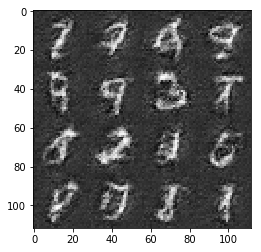

Epoch 2/2... Discriminator Loss: 0.0452... Generator Loss: 3.5903
Epoch 2/2... Discriminator Loss: 0.1623... Generator Loss: 2.1329
Epoch 2/2... Discriminator Loss: 0.0433... Generator Loss: 3.6642
Epoch 2/2... Discriminator Loss: 0.0097... Generator Loss: 5.8974
Epoch 2/2... Discriminator Loss: 0.0984... Generator Loss: 2.6405


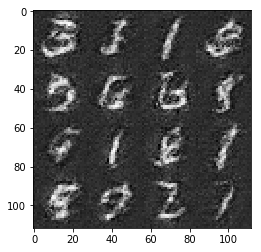

Epoch 2/2... Discriminator Loss: 0.0150... Generator Loss: 4.9595
Epoch 2/2... Discriminator Loss: 0.0694... Generator Loss: 3.0952
Epoch 2/2... Discriminator Loss: 0.0721... Generator Loss: 3.1268
Epoch 2/2... Discriminator Loss: 0.0326... Generator Loss: 3.8873
Epoch 2/2... Discriminator Loss: 0.0682... Generator Loss: 3.2037


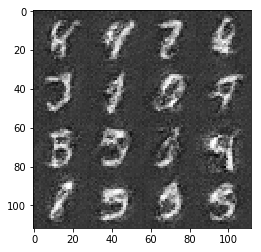

Epoch 2/2... Discriminator Loss: 0.0898... Generator Loss: 2.8792
Epoch 2/2... Discriminator Loss: 0.0126... Generator Loss: 7.1555
Epoch 2/2... Discriminator Loss: 0.0350... Generator Loss: 3.8590
Epoch 2/2... Discriminator Loss: 0.1209... Generator Loss: 2.6642
Epoch 2/2... Discriminator Loss: 0.0332... Generator Loss: 4.0261


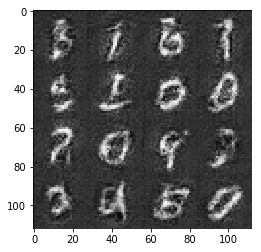

Epoch 2/2... Discriminator Loss: 0.1744... Generator Loss: 2.1942
Epoch 2/2... Discriminator Loss: 0.0711... Generator Loss: 3.2611
Epoch 2/2... Discriminator Loss: 0.0075... Generator Loss: 6.1755
Epoch 2/2... Discriminator Loss: 0.0949... Generator Loss: 2.8632
Epoch 2/2... Discriminator Loss: 0.1308... Generator Loss: 2.5182


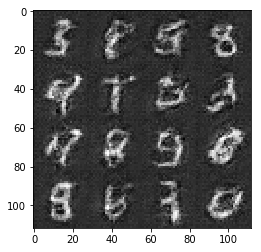

Epoch 2/2... Discriminator Loss: 0.0185... Generator Loss: 4.5831
Epoch 2/2... Discriminator Loss: 0.2917... Generator Loss: 1.9202
Epoch 2/2... Discriminator Loss: 5.5060... Generator Loss: 6.2137
Epoch 2/2... Discriminator Loss: 1.2321... Generator Loss: 3.7054
Epoch 2/2... Discriminator Loss: 0.6403... Generator Loss: 1.7891


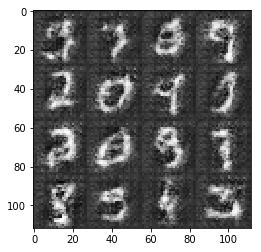

Epoch 2/2... Discriminator Loss: 0.3379... Generator Loss: 2.5171
Epoch 2/2... Discriminator Loss: 0.3806... Generator Loss: 1.7838
Epoch 2/2... Discriminator Loss: 0.2767... Generator Loss: 2.5328
Epoch 2/2... Discriminator Loss: 3.7535... Generator Loss: 6.5984
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 3.1193


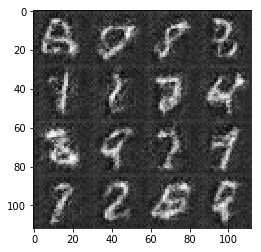

Epoch 2/2... Discriminator Loss: 0.2840... Generator Loss: 1.8850
Epoch 2/2... Discriminator Loss: 0.4575... Generator Loss: 3.7153
Epoch 2/2... Discriminator Loss: 0.3181... Generator Loss: 1.6816
Epoch 2/2... Discriminator Loss: 0.3514... Generator Loss: 1.6399
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 0.8461


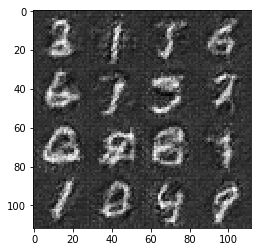

Epoch 2/2... Discriminator Loss: 0.4900... Generator Loss: 2.8324
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 0.3815... Generator Loss: 1.5032
Epoch 2/2... Discriminator Loss: 0.3865... Generator Loss: 1.4240


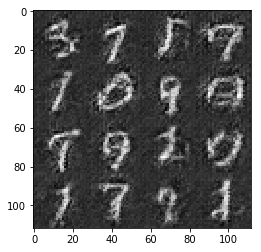

Epoch 2/2... Discriminator Loss: 0.3467... Generator Loss: 1.5516
Epoch 2/2... Discriminator Loss: 0.2161... Generator Loss: 1.9136
Epoch 2/2... Discriminator Loss: 0.1392... Generator Loss: 2.4650
Epoch 2/2... Discriminator Loss: 0.0697... Generator Loss: 3.4342
Epoch 2/2... Discriminator Loss: 0.0644... Generator Loss: 3.2137


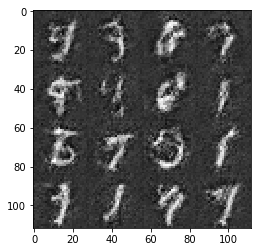

Epoch 2/2... Discriminator Loss: 0.1754... Generator Loss: 2.2208
Epoch 2/2... Discriminator Loss: 0.1306... Generator Loss: 2.5138
Epoch 2/2... Discriminator Loss: 0.0634... Generator Loss: 3.3204
Epoch 2/2... Discriminator Loss: 0.0547... Generator Loss: 3.3494
Epoch 2/2... Discriminator Loss: 0.0580... Generator Loss: 3.3413


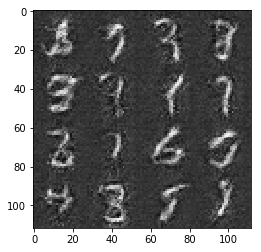

Epoch 2/2... Discriminator Loss: 0.0514... Generator Loss: 3.3010
Epoch 2/2... Discriminator Loss: 0.0333... Generator Loss: 4.0721
Epoch 2/2... Discriminator Loss: 0.0967... Generator Loss: 2.9086
Epoch 2/2... Discriminator Loss: 0.0894... Generator Loss: 2.7866
Epoch 2/2... Discriminator Loss: 0.0160... Generator Loss: 4.8543


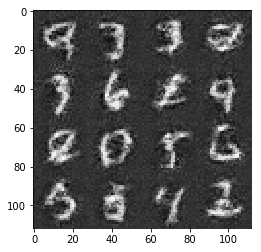

Epoch 2/2... Discriminator Loss: 0.0379... Generator Loss: 3.9046
Epoch 2/2... Discriminator Loss: 0.0638... Generator Loss: 3.4266
Epoch 2/2... Discriminator Loss: 0.0337... Generator Loss: 4.0473
Epoch 2/2... Discriminator Loss: 0.0476... Generator Loss: 3.3918
Epoch 2/2... Discriminator Loss: 0.2186... Generator Loss: 2.0306


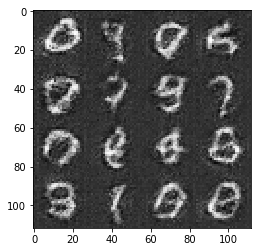

Epoch 2/2... Discriminator Loss: 0.0082... Generator Loss: 5.5654
Epoch 2/2... Discriminator Loss: 0.0580... Generator Loss: 3.2812
Epoch 2/2... Discriminator Loss: 0.2850... Generator Loss: 1.6501
Epoch 2/2... Discriminator Loss: 0.0109... Generator Loss: 4.9806
Epoch 2/2... Discriminator Loss: 0.0430... Generator Loss: 3.5978


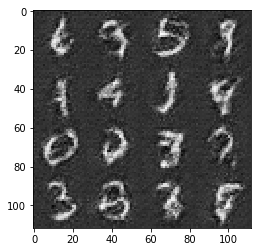

Epoch 2/2... Discriminator Loss: 0.0428... Generator Loss: 3.4890
Epoch 2/2... Discriminator Loss: 0.0939... Generator Loss: 2.8843
Epoch 2/2... Discriminator Loss: 0.1357... Generator Loss: 4.4431
Epoch 2/2... Discriminator Loss: 2.0763... Generator Loss: 3.9698
Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 2.0536


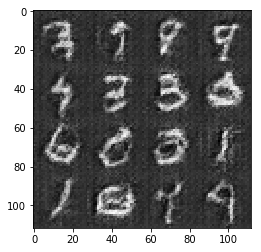

Epoch 2/2... Discriminator Loss: 1.6048... Generator Loss: 5.5905
Epoch 2/2... Discriminator Loss: 0.3438... Generator Loss: 4.4326
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 3.3490
Epoch 2/2... Discriminator Loss: 0.4622... Generator Loss: 1.3696
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.7518


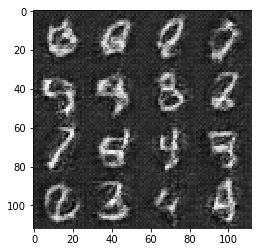

Epoch 2/2... Discriminator Loss: 0.3547... Generator Loss: 2.0389
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 1.4265
Epoch 2/2... Discriminator Loss: 0.3339... Generator Loss: 1.6900
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 0.9984


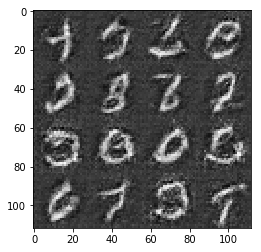

Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 0.3470... Generator Loss: 1.4405


In [55]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 2.2219
Epoch 1/1... Discriminator Loss: 0.1456... Generator Loss: 4.5120
Epoch 1/1... Discriminator Loss: 3.0573... Generator Loss: 0.0778
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 2.1734... Generator Loss: 0.2554


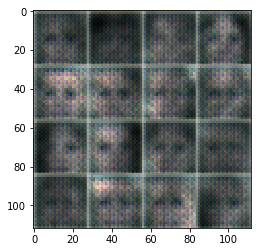

Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 6.2484
Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 3.4597
Epoch 1/1... Discriminator Loss: 0.1500... Generator Loss: 4.0754
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 1.3589
Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 5.2319


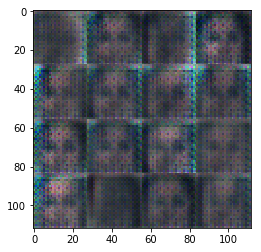

Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 4.9504
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 5.7156
Epoch 1/1... Discriminator Loss: 6.3164... Generator Loss: 0.0075
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 4.1507... Generator Loss: 6.1771


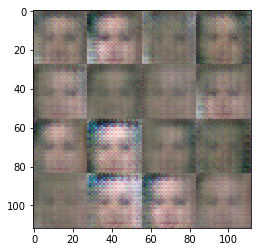

Epoch 1/1... Discriminator Loss: 0.2623... Generator Loss: 1.8920
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 7.3160
Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 6.4195
Epoch 1/1... Discriminator Loss: 0.1169... Generator Loss: 2.9204
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 1.3470


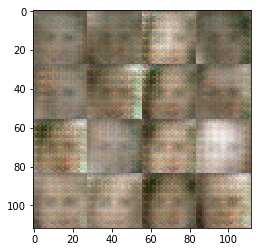

Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 0.3060
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.5512


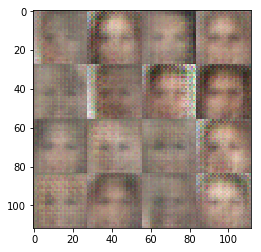

Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.7786


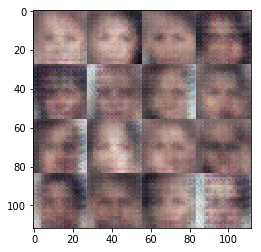

Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8690


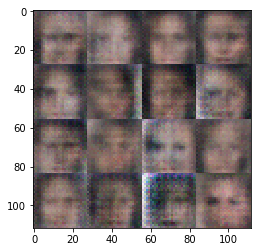

Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 0.9955


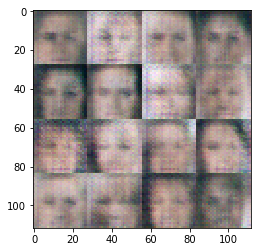

Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.4482
Epoch 1/1... Discriminator Loss: 2.3973... Generator Loss: 3.1961
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 0.2034... Generator Loss: 2.2192
Epoch 1/1... Discriminator Loss: 2.9472... Generator Loss: 7.3988


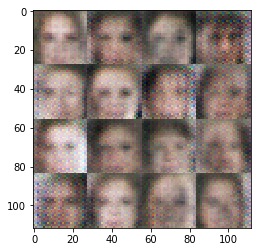

Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 4.0263
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 0.2220... Generator Loss: 2.6044
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 4.9396


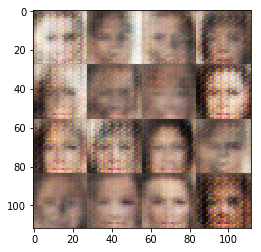

Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 6.8478
Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 0.0288... Generator Loss: 3.9959
Epoch 1/1... Discriminator Loss: 0.1197... Generator Loss: 2.3785
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 10.8305


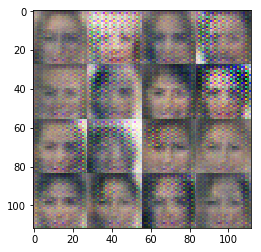

Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 6.6500
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 8.2731
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 9.8979
Epoch 1/1... Discriminator Loss: 0.0799... Generator Loss: 3.3180
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 4.9679


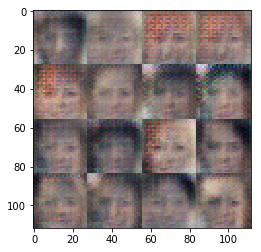

Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 2.0848
Epoch 1/1... Discriminator Loss: 0.1727... Generator Loss: 2.7244
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.3571
Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 8.3325


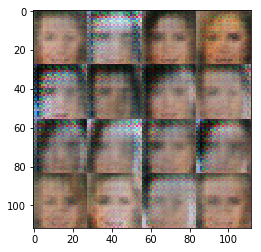

Epoch 1/1... Discriminator Loss: 0.1589... Generator Loss: 2.0828
Epoch 1/1... Discriminator Loss: 0.0195... Generator Loss: 8.6330
Epoch 1/1... Discriminator Loss: 0.0598... Generator Loss: 3.7262
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 7.4808
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 8.6571


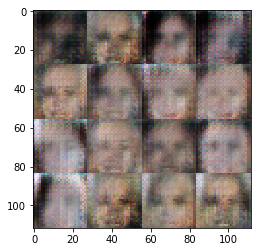

Epoch 1/1... Discriminator Loss: 0.2896... Generator Loss: 2.4457
Epoch 1/1... Discriminator Loss: 0.2193... Generator Loss: 1.8839
Epoch 1/1... Discriminator Loss: 2.6879... Generator Loss: 4.8210
Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 1.5535
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.0382


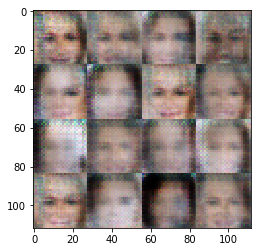

Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 1.7369
Epoch 1/1... Discriminator Loss: 0.0417... Generator Loss: 4.1276
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 2.4132


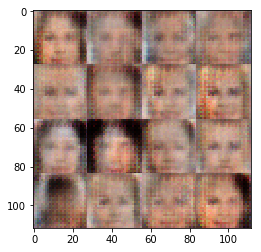

Epoch 1/1... Discriminator Loss: 0.0607... Generator Loss: 5.5584
Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 3.9357
Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 3.7102
Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 4.9551
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 6.5441


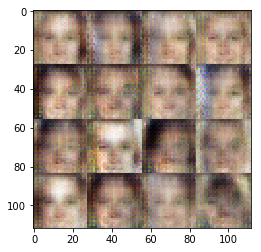

Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 9.0550
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 9.6408
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 7.3826
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 5.1259
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 8.5685


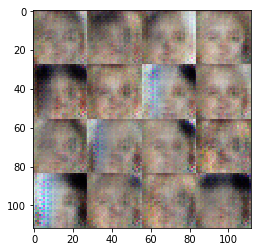

Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 7.3275
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 7.1754
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 8.6887
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 5.2231
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 7.8982


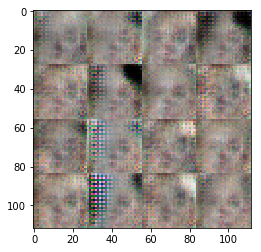

Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 9.5066
Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 2.3753
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 6.1193
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 9.3710
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 9.7092


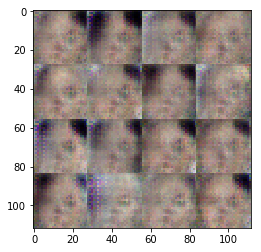

Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 9.3005
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 5.3384
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 9.4001
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 8.4707
Epoch 1/1... Discriminator Loss: 4.6913... Generator Loss: 0.3416


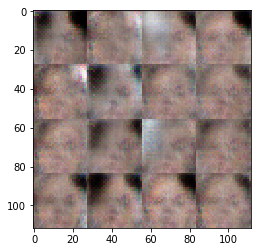

Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.2026
Epoch 1/1... Discriminator Loss: 2.1357... Generator Loss: 0.2794
Epoch 1/1... Discriminator Loss: 3.4710... Generator Loss: 5.1950
Epoch 1/1... Discriminator Loss: 1.9196... Generator Loss: 4.0041
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 0.8086


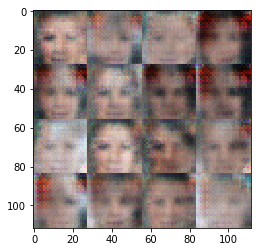

Epoch 1/1... Discriminator Loss: 2.0369... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 1.6754
Epoch 1/1... Discriminator Loss: 2.1814... Generator Loss: 3.6498


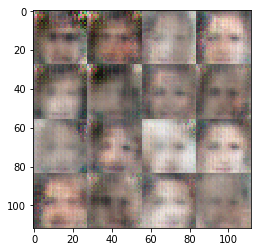

Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.4331
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.7294
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.5024


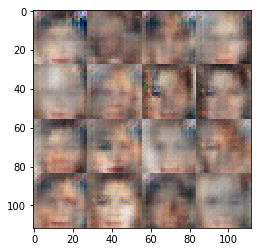

Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 2.5085... Generator Loss: 4.1919
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.4545


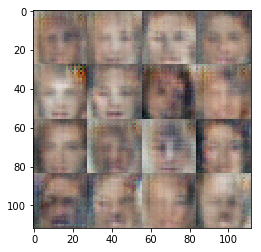

Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 2.1560
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.5883


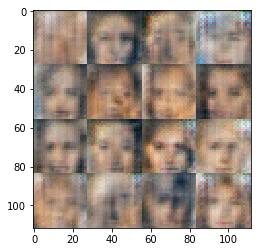

Epoch 1/1... Discriminator Loss: 1.6595... Generator Loss: 1.4940
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.2835
Epoch 1/1... Discriminator Loss: 2.5067... Generator Loss: 4.6720
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 2.0028
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 2.6042


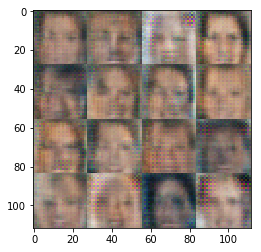

Epoch 1/1... Discriminator Loss: 1.8789... Generator Loss: 0.2219
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 2.7621... Generator Loss: 0.0953
Epoch 1/1... Discriminator Loss: 0.1810... Generator Loss: 3.1582


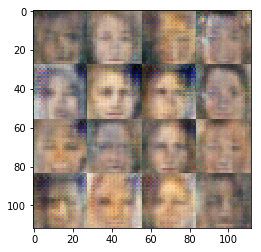

Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.3909
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 2.0130... Generator Loss: 0.1867
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.6830


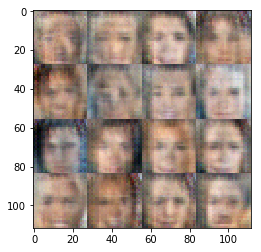

Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 2.0335
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.5041
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 2.0613... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.3628


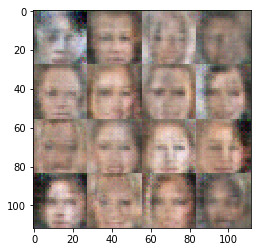

Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 1.6631
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 3.4308


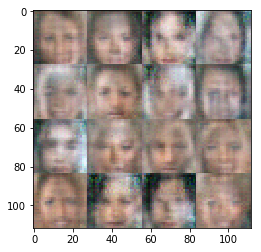

Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 3.7014
Epoch 1/1... Discriminator Loss: 2.2923... Generator Loss: 0.3135
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.9356


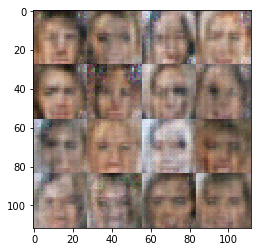

Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 1.8935
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 2.8427... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 1.7958


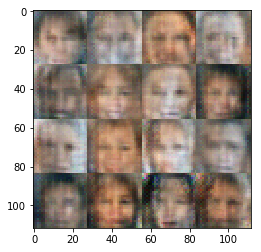

Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 2.1744... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 5.2441
Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 1.6921


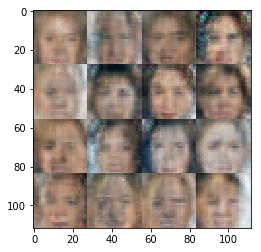

Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.3782
Epoch 1/1... Discriminator Loss: 0.2079... Generator Loss: 2.0705
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.5681


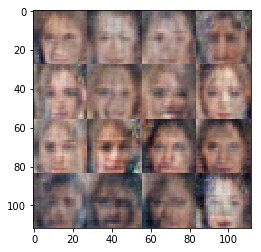

Epoch 1/1... Discriminator Loss: 0.3088... Generator Loss: 5.7348
Epoch 1/1... Discriminator Loss: 0.1617... Generator Loss: 2.2083
Epoch 1/1... Discriminator Loss: 0.2957... Generator Loss: 5.2692
Epoch 1/1... Discriminator Loss: 0.0309... Generator Loss: 4.6129
Epoch 1/1... Discriminator Loss: 0.1539... Generator Loss: 4.9651


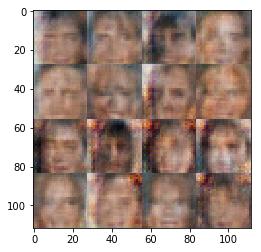

Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 2.8011
Epoch 1/1... Discriminator Loss: 0.2129... Generator Loss: 1.9293
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 4.6395
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 2.0921
Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 7.3674


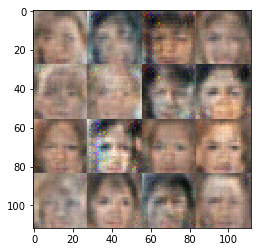

Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 7.6556
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 6.3428
Epoch 1/1... Discriminator Loss: 0.0080... Generator Loss: 5.7112
Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 4.2579
Epoch 1/1... Discriminator Loss: 0.3070... Generator Loss: 1.5508


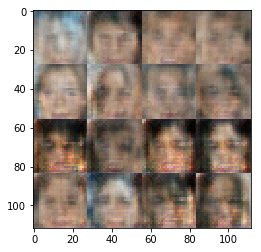

Epoch 1/1... Discriminator Loss: 0.0042... Generator Loss: 6.9905
Epoch 1/1... Discriminator Loss: 4.2133... Generator Loss: 4.5448
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 5.7057
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 1.9891


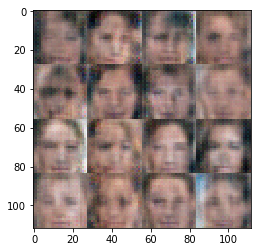

Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 1.3858
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.4398
Epoch 1/1... Discriminator Loss: 0.3139... Generator Loss: 1.9443
Epoch 1/1... Discriminator Loss: 0.0997... Generator Loss: 2.8549
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 7.0036


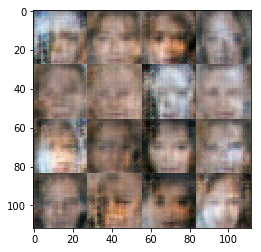

Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 0.1074... Generator Loss: 7.8100
Epoch 1/1... Discriminator Loss: 8.8317... Generator Loss: 9.8529
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 1.5276
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 0.8244


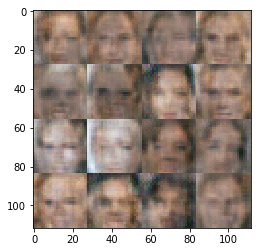

Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 5.1306
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 2.6703
Epoch 1/1... Discriminator Loss: 0.0143... Generator Loss: 4.8297


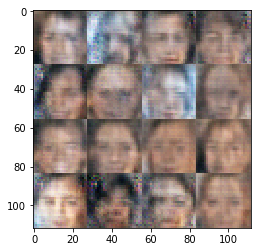

Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 4.2030
Epoch 1/1... Discriminator Loss: 3.8792... Generator Loss: 5.4769
Epoch 1/1... Discriminator Loss: 3.3254... Generator Loss: 0.0648
Epoch 1/1... Discriminator Loss: 1.8813... Generator Loss: 2.1686


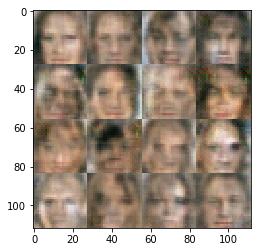

Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.7983
Epoch 1/1... Discriminator Loss: 0.4614... Generator Loss: 1.7528
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 5.7783


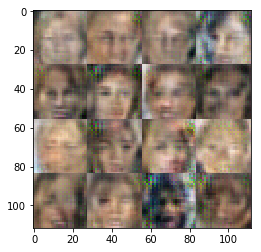

Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 4.9559
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.5481


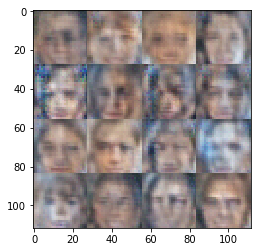

Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 0.0994... Generator Loss: 3.1639
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8757


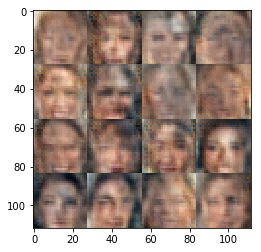

Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.9739
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.2292


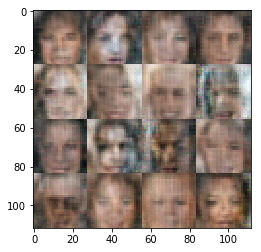

Epoch 1/1... Discriminator Loss: 0.2556... Generator Loss: 2.6126
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.5667


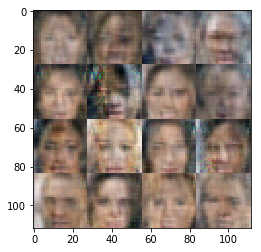

Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 1.5486
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.5033


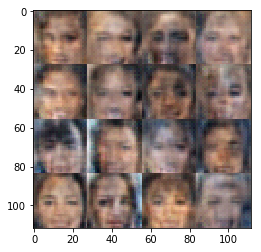

Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.6177
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.4440


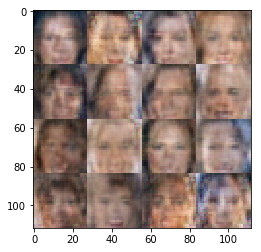

Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 2.1637
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 1.6396... Generator Loss: 3.2053
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 4.1905


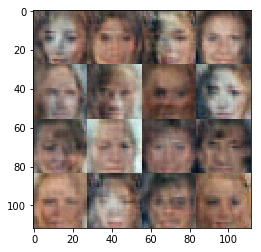

Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 2.1567... Generator Loss: 2.2931
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 1.5394
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 1.0419


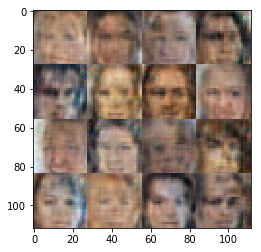

Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 1.3478
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.3312


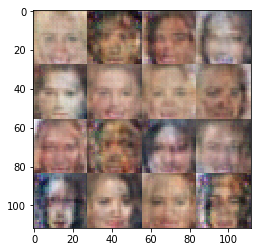

Epoch 1/1... Discriminator Loss: 1.8283... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.8527


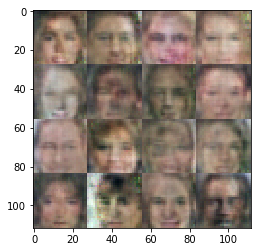

Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 2.9510
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 3.6144
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.5512


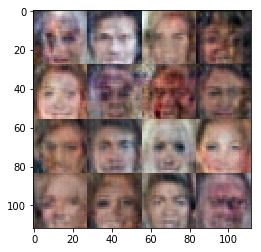

Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.4721
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 0.9751


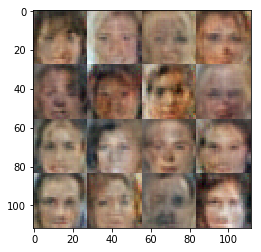

Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 0.7251


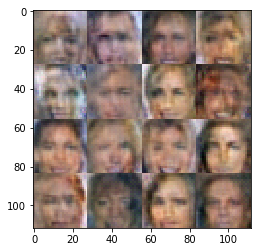

Epoch 1/1... Discriminator Loss: 0.2297... Generator Loss: 2.5627
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 5.3557
Epoch 1/1... Discriminator Loss: 0.3134... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 0.2197... Generator Loss: 2.6456


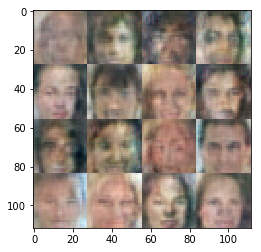

Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 3.7893
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 2.7972
Epoch 1/1... Discriminator Loss: 2.1968... Generator Loss: 0.1590
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 1.5648
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.4554


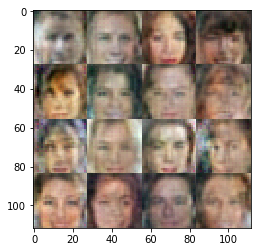

Epoch 1/1... Discriminator Loss: 2.2380... Generator Loss: 0.1290
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 0.2054... Generator Loss: 2.4577
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 1.9348... Generator Loss: 4.1698


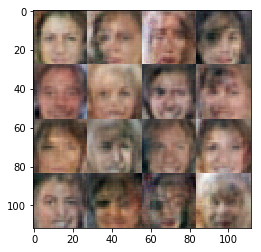

Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 4.6655
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.3816
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.4039


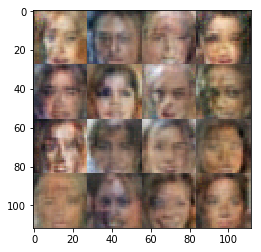

Epoch 1/1... Discriminator Loss: 0.2327... Generator Loss: 2.4474
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 0.7035


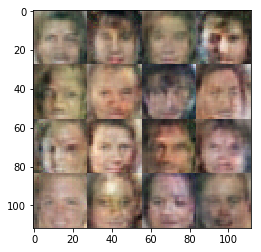

Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.4060
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.4152


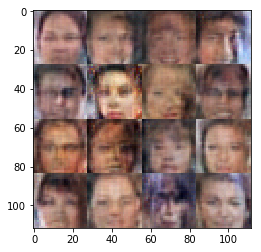

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.3955


In [56]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.